In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import pickle

In [271]:
df_movies = pd.read_csv('static/data/movies.csv')
df_movies['year'] = df_movies['title'].str[-5:-1] # get year from title into 'year' column
#df_movies['title'] = df_movies['title'].str[:-6] # remove year from title
df_movies

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017
9739,193585,Flint (2017),Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018


In [272]:
df_ratings = pd.read_csv('static/data/ratings.csv')
df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
df_ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51
...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22
100832,610,168248,5.0,2017-05-03 22:21:31
100833,610,168250,5.0,2017-05-08 19:50:47
100834,610,168252,5.0,2017-05-03 21:19:12


In [273]:
# start data cleaning
df_movies_duplicated = df_movies[df_movies.duplicated(['title', 'year'], keep=False)].sort_values('title')
df_movies_duplicated

,movieId,title,genres,year
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller,2002
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller,2002
650,838,Emma (1996),Comedy|Drama|Romance,1996
5601,26958,Emma (1996),Romance,1996
5854,32600,Eros (2004),Drama,2004
9135,147002,Eros (2004),Drama|Romance,2004
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller,1980
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller,1980
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller,2005
6932,64997,War of the Worlds (2005),Action|Sci-Fi,2005


In [274]:
# key is id to remove, value the id to keep
duplicated_movieIds = {
    6003: 144606,
    26958: 838,
    32600: 147002,
    168358: 2851,
    64997: 34048
}

In [275]:
# check if duplicated movies have a rating
pd.Series(duplicated_movieIds.keys()).isin(df_ratings['movieId'])

0    True
1    True
2    True
3    True
4    True
dtype: bool

In [276]:
# drop duplicated movieIds with less genre information
df_movies = df_movies[~df_movies['movieId'].isin(duplicated_movieIds.keys())]
df_movies

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017
9739,193585,Flint (2017),Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018


In [277]:
# in ratings change movieIDs of duplicated movies to the kept movieID
for dropped_id, kept_id in duplicated_movieIds.items():
    df_ratings.loc[df_ratings['movieId'] == dropped_id, 'movieId'] = kept_id
# check for duplicates again
pd.Series(duplicated_movieIds.keys()).isin(df_ratings['movieId'])

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [278]:
# check for duplicate ratings
df_ratings[df_ratings.duplicated(['userId', 'movieId'], keep=False)]

,userId,movieId,rating,timestamp
4590,28,34048,3.5,2009-02-13 09:13:40
4747,28,34048,3.5,2009-02-17 05:54:35
11241,68,34048,2.0,2006-09-17 22:30:46
11451,68,34048,2.5,2008-12-28 20:55:15
17449,111,144606,4.0,2018-01-20 17:15:31
17819,111,144606,4.0,2018-01-31 23:27:37
80405,509,838,3.5,2015-07-04 17:42:03
80596,509,838,3.5,2015-07-04 17:42:33


In [279]:
# keep latest entry
duplicate_rating_indexes = df_ratings[df_ratings.duplicated(['userId', 'movieId'], keep='last')].index
df_ratings = df_ratings[~df_ratings.index.isin(duplicate_rating_indexes)]
df_ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51
...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22
100832,610,168248,5.0,2017-05-03 22:21:31
100833,610,168250,5.0,2017-05-08 19:50:47
100834,610,168252,5.0,2017-05-03 21:19:12


In [280]:
df_merge = df_ratings.merge(df_movies, how='left', on='movieId')
df_merge

,userId,movieId,rating,timestamp,title,genres,year
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),Comedy|Romance,1995
2,1,6,4.0,2000-07-30 18:37:04,Heat (1995),Action|Crime|Thriller,1995
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995
...,...,...,...,...,...,...,...
100827,610,166534,4.0,2017-05-03 21:53:22,Split (2017),Drama|Horror|Thriller,2017
100828,610,168248,5.0,2017-05-03 22:21:31,John Wick: Chapter Two (2017),Action|Crime|Thriller,2017
100829,610,168250,5.0,2017-05-08 19:50:47,Get Out (2017),Horror,2017
100830,610,168252,5.0,2017-05-03 21:19:12,Logan (2017),Action|Sci-Fi,2017


In [281]:
Ratings = df_merge.pivot(index='userId', columns='title', values='rating')
Ratings.to_csv('static/data/ratings_pivot_table.csv')
# drop movies with less than 20 reviews
Ratings = Ratings.dropna(axis=1, thresh=20)
Ratings

title,(500) Days of Summer (2009),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),13 Going on 30 (2004),"13th Warrior, The (1999)",1408 (2007),2001: A Space Odyssey (1968),2012 (2009),...,Young Frankenstein (1974),Young Guns (1988),Zack and Miri Make a Porno (2008),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.5,3.5,NaN


In [282]:
Ratings = Ratings.fillna(Ratings.mean())
Ratings

title,(500) Days of Summer (2009),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),13 Going on 30 (2004),"13th Warrior, The (1999)",1408 (2007),2001: A Space Odyssey (1968),2012 (2009),...,Young Frankenstein (1974),Young Guns (1988),Zack and Miri Make a Porno (2008),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.666667,3.527778,3.074468,3.431818,4.149123,3.190476,4.000000,3.16,3.894495,2.619048,...,5.000000,3.1,3.52381,3.710526,3.877358,3.509259,3.890625,3.863636,2.770833,4.000000
2,3.666667,3.527778,3.074468,3.431818,4.149123,3.190476,2.903846,3.16,3.894495,2.619048,...,3.992754,3.1,3.52381,3.710526,3.000000,3.509259,3.890625,3.863636,2.770833,3.134615
3,3.666667,3.527778,3.074468,3.431818,4.149123,3.190476,2.903846,3.16,3.894495,0.500000,...,3.992754,3.1,3.52381,3.710526,3.877358,3.509259,3.890625,3.863636,2.770833,3.134615
4,3.666667,3.527778,3.074468,3.431818,5.000000,3.190476,2.903846,3.16,3.894495,2.619048,...,3.992754,3.1,3.52381,3.710526,3.877358,3.509259,3.890625,3.863636,2.770833,3.134615
5,3.666667,3.527778,3.074468,3.431818,4.149123,3.190476,2.903846,3.16,3.894495,2.619048,...,3.992754,3.1,3.52381,3.710526,3.877358,3.509259,3.890625,3.863636,2.770833,3.134615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.666667,3.527778,3.074468,3.431818,4.149123,3.190476,2.903846,3.16,5.000000,2.619048,...,3.500000,3.1,3.52381,3.710526,3.877358,3.509259,3.890625,3.863636,2.770833,3.134615
607,3.666667,3.527778,3.074468,3.431818,4.149123,3.190476,2.903846,3.16,3.894495,2.619048,...,3.992754,3.1,3.52381,3.710526,3.877358,3.509259,3.890625,3.863636,2.770833,3.134615
608,3.666667,3.527778,3.074468,3.431818,4.149123,3.190476,2.903846,3.16,3.000000,2.619048,...,3.992754,3.1,3.52381,3.710526,3.877358,3.000000,3.890625,4.500000,3.500000,3.134615


In [283]:
pca = PCA()
W = pca.fit_transform(Ratings)

In [284]:
list(pca.explained_variance_ratio_)

[0.04799170187127104,
 0.022309957722935092,
 0.019985981925015675,
 0.01564758620541208,
 0.015169607747085976,
 0.013787765754352024,
 0.012497732503462047,
 0.012322886910198701,
 0.011319340808048675,
 0.011166680408795744,
 0.010453185373356908,
 0.01028971051331857,
 0.009968789223453617,
 0.009711448529704738,
 0.00949014796289596,
 0.009118196959265567,
 0.00863909667318946,
 0.008553479802914906,
 0.008372709899760026,
 0.008151392153495862,
 0.007862371559489488,
 0.0077836881091060284,
 0.007725550077338639,
 0.007605625423005207,
 0.007513005952398138,
 0.007421546366027153,
 0.007178355851713443,
 0.007074024058592456,
 0.007021081498135027,
 0.006804696599632123,
 0.006792074779576427,
 0.006673682161245055,
 0.006636030812520347,
 0.006494052808288811,
 0.006344605601817773,
 0.006276338259683082,
 0.006153350707160241,
 0.006053779236906847,
 0.005988509189100599,
 0.005806501244274253,
 0.005737231833820654,
 0.005679542706061825,
 0.005594187735474893,
 0.005492599696

Text(0, 0.5, 'explained variance [%]')

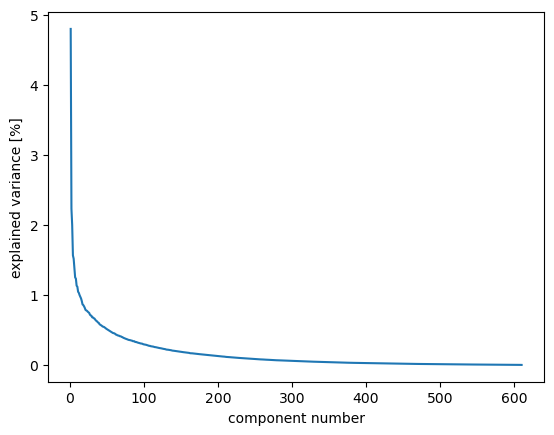

In [285]:
component_no = np.arange(1, W.shape[1]+1)
plt.plot(component_no, pca.explained_variance_ratio_*100 )
plt.xlabel("component number")
plt.ylabel("explained variance [%]")

Text(0, 0.5, 'explained variance [%]')

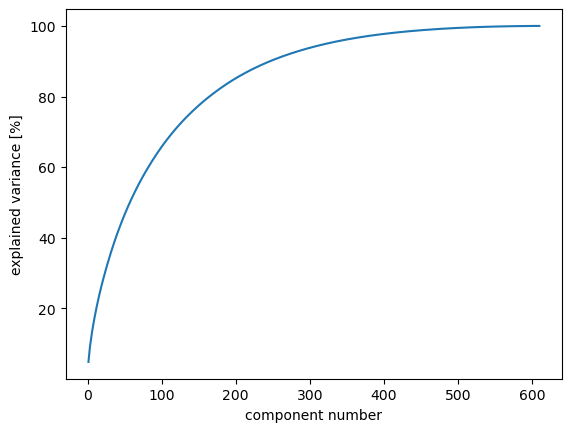

In [286]:
plt.plot(component_no, np.cumsum(pca.explained_variance_ratio_*100) )
plt.xlabel("component number")
plt.ylabel("explained variance [%]")

In [287]:
nmf_model = NMF(n_components=200, max_iter=2000)
nmf_model.fit_transform(Ratings)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.72664114,
        0.54840718],
       [0.        , 0.        , 0.        , ..., 0.        , 0.70870767,
        0.52910287],
       [0.        , 0.        , 0.        , ..., 0.27834082, 0.17075503,
        0.18659997],
       ...,
       [0.        , 0.        , 0.        , ..., 0.26633896, 0.18466994,
        0.13611127],
       [0.14645656, 0.        , 0.        , ..., 0.00459796, 0.00618252,
        0.99515824],
       [0.        , 0.        , 0.        , ..., 0.22225134, 0.17819873,
        0.15825163]])

In [288]:
def get_nmf_recommendations(query, model, Ratings, k=10):
    """
    Filters and recommends the top k movies for any given input query based on a trained NMF model. 
    Returns a list of k movie ids.
    """
    # 1. candidate generation
    
    # construct new_user-item dataframe given the query
    df_new_user = pd.DataFrame(
        data=query,
        columns=model.feature_names_in_,
        index = ['new_user']
    )

    df_new_user_imputed = df_new_user.fillna(Ratings.mean())

    # 2. scoring
    
    # calculate the score with the NMF model
    Q_matrix = model.components_

    P_new_user_matrix = model.transform(df_new_user_imputed)
    R_hat_new_user_matrix = np.dot(P_new_user_matrix, Q_matrix)
    R_hat_new_user_df = pd.DataFrame(
        data=R_hat_new_user_matrix,
        columns=model.feature_names_in_,
        index = ['new_user']
    )
    
    # 3. ranking
    
    recommendations = list(R_hat_new_user_df.transpose()
        .drop(query.keys())  # filter out movies allready seen by the user
        .sort_values(ascending=False, by='new_user') # return the top-k highest rated movie ids or titles
        .head(k).index
    )
    
    return recommendations

get_nmf_recommendations({}, nmf_model, Ratings, 10)

['Shawshank Redemption, The (1994)',
 'Streetcar Named Desire, A (1951)',
 'Pulp Fiction (1994)',
 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)',
 'Godfather, The (1972)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Harold and Maude (1971)',
 'Matrix, The (1999)',
 'Lawrence of Arabia (1962)',
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)']

In [289]:
with open('static/model/nmf_model_movielens.pkl',mode='wb') as file:
    pickle.dump(nmf_model,file)